# Project 1: Basic Classification - Kickstarter Projects

## carlos.e.hernandez@<>.com
### Slack: carlosh

# Requirements X

For one of the projects (but not for Project 1), you will work with your mentor to choose your own dataset in place of the one listed in the table which is suitablefor the project's topic. You will present this project to a wider audience including mentees in the basic ML course.

All projects should be submitted as Jupyter notebooks with clean and well commented code. They should run end-to-end with required packages listed in a separate text file. Please incorporate the following in the notebook (the length of each section will vary project to project): 

1. Problem definition is clearly described including discussion on what metric could be the most relevant to the business problem.
1. Data Quality is checked and handled appropriately - missing values, date formats, outliers, ...
1. Exploratory Data Analysis is performed for target and top variables.
1. Feature Engineering is applied to relevant columns - free text, categorical, date and other types - depending on the modelling technique.
1. Machine Learning models are built and evaluated based on an appropriate validation schema. Multiple approaches are tried.
1. Results of the final model are described including, e.g., the relationship between top predictors and the target.
1. Discussion on whether the solution to the business problem is good enough, the main insights, and next possible steps.
1. Code is clean, well documented and runs end-to-end. Required packages including versions are listed in a separate text file.

# Introduction

Crowdfunding has been increasingly getting more visibility and credibility in the past few years after having successfully funded and launched products and services.

However, despite being an option for starting projects, the rate of failed projects is still staggering. The reasons are many, but it often reduces to projects overcomitting and under-delivering promises or to projects understimating how much money they will actually need to successfully kickstart a project.

In this project, I'll try to produce a model that predicts the final state of a project in kickstarter given a set of features. In other words this will be treated as a **multi-class classification problem**. I'll aim to see whether a project will fail, succeed, be canceled, etc.

I'll use the dataset compiled by the Kaggle user Kemical on https://www.kaggle.com/kemical/kickstarter-projects.

# Imports and tools

In [ ]:
%matplotlib inline

from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPClassifier

# Connect to Google Drive if hosting the files there
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
def print_marquee(msg: str):
    """
    Prints a centered message with a marquee of * 
    """
    marquee_width = len(msg) + 4
    print("\n")
    print("*" * marquee_width)
    print(f"* {msg} *")
    print("*" * marquee_width)

def print_metrics(y_true, y_pred):
    """
    Prints a Confusion Matrix, the ammount of miscategorized elements and the
    classification report with Precision, recall, accuracy and F1-Scores
    """
    print(metrics.confusion_matrix(y_true, y_pred))
    print("Wrongly categorized elements: %d/%d" 
      % ((y_true != y_pred).sum(), y_true.shape[0]))
    
    print("\n")
    print(metrics.classification_report(y_true, y_pred))

def search_and_evaluate_model(param_searcher, X, y, X_tst, y_tst, 
                              columns_to_drop: list=["ID"]):
    """
    Uses a param searcher, fits models and prints the report for the hyperparam
    search along with the confusion matrix and prediction report on the val set
    """

    print_marquee("Searching for optimal hyperparameters...")

    param_searcher.fit(X.drop(columns_to_drop, axis=1),
                       y)
    
    print("The best hyperparameters are %s with a score of %0.2f"
        % (param_searcher.best_params_, param_searcher.best_score_))
    

    print_marquee("Hyperparam search report")
    result_report = pd.DataFrame.from_dict(param_searcher.cv_results_)
    display(result_report)

    print_marquee("Confusion Matrix and Prediction Report on Validation set:")
    y_pred = param_searcher.predict(X_tst.drop(columns_to_drop, axis=1))
    print_metrics(y_tst, y_pred)

def model_2_pkl(model, filename: str):
    """Exports a model to PKL format"""
    pickle.dump(model, open(filename, 'wb'))

def pkl_2_model(filename: str):
    """Loads a model from a PKL file"""
    return pickle.load(open(filename, 'rb'))

def plot_histogram(df: pd.DataFrame, nrows: int, ncols: int):
    """
    Plots a series of histograms for a dataframe in a nrows x ncols distribution
    """
    fig, ax = plt.subplots(nrows=nrows,
                           ncols=ncols,
                           figsize=(14,14))
    
    for n, col in enumerate(df.columns):
        plt.subplot(nrows, ncols, n+1)
        df[col].plot.hist(ax = plt.gca(),
                          bins=20,
                          legend=True)

# Data

The following data was pulled from over 300,000 Kickstarter projects spanning successful projects, funded but unsucessful projects or just projects that failed from the outset.

I'll try to predict the final state of the project given the properties of its crowdfunding campaign. We have the following independent variables:

## Independent Variables

1. ID (numerical). The unique ID of the project, doesn't seem to provide any statistica information.
1. name (str). The name of the campaign. We might be able to extract some information from it after tokenizing the field.
1. category (categorical). The subcategory to which the project belongs.
1. main_category (categorical). The parent category to which the project belongs.
1. currency (categorical). The currency used for the funds.
1. deadline (datetime). The hard end date of the campaign, if funds haven't been raised by this date, the project may be deemed failed.
1. goal (float). The fund raising goal for the project expressed in *currency*.
1. launched (datetime). The date at which the campaign was launched.
1. pledged (float). Pledged amount for the project in *currency*.
1. backers (int). The number of individual backers or contributors that have pledged some amount of money to the project.
1. country (categorical). The country from which the campaign was launched.
1. usd_pledged (float). The amount pledged to the project converted to USD by Kickstarter's API.
1. usd_pledged_real (float). The amount pledged to the project converted to USD by fixer.io's real time API. This amount takes into account inflation (i.e. gets the current value of the USD)
1. usd_goal_real (float).  The goal amount of the project converted to USD by fixer.io's real time API. This amount takes into account inflation (i.e. gets the current value of the USD)

## Dependent variable
1. state (categorical). Represents the final status of the crowdfunding campaign, it can be one of the following values:

 1. canceled. If the campaign was canceled by the project owners or site admins.
 1. failed. If the campaign failed to meet its goal by the deadline.
 1. live. If the campaign is still ongoing and its final state hasn't been determined yet.
 1. successful. If the campaign successfully raised at least its goal but is yet to deliver a real product or service.
 1. suspended. If the campaign has been temporarily suspended at the request of the project owners or site admins.
 1. undefined. If the state of a campaign cannot be determined with certainty.



In [ ]:
# Change this line to the folder that contains the data file
#data_root_location = "/content/drive/MyDrive/Oracle/Assignment1/"
data_root_location = "/workspace/aprauto/FinalProject/"

data_filename = "ks-projects-201801.csv"

data = pd.read_csv(f"{data_root_location}{data_filename}",
                   header=0,
                   dtype={
                       "category": "category",
                       "main_category": "category",
                       "currency": "category",
                       "state": "category",
                       "country": "category"
                   },
                   parse_dates=["deadline", "launched"])

print(f"Data: {data.shape}")
data.head()

Data: (378661, 15)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## A note on Data leakage

The nature of a Kickstarter project makes it possible to conceptualize the problem where we could slice the current parameters of an ongoing campaign to see how it will fare based on the output of past campaigns.

While it could be argued that we could leave the data as it is, for this project. Given that a campaign will be successful if pledged > goal, let's remove a couple of columns so as to avoid data leakages.

1. pledged
1. usd_pledged
1. usd_pledged_real

In [ ]:
data.drop(["pledged", "usd pledged", "usd_pledged_real"], axis=1, inplace=True)

## EDA

Before we begin a proper Exploratory Data Analysis, let's begin with doing some brief description of the data: how many columns and rows there are, what are their names, how many records in each *state* category there are, etc.

In [ ]:
print(f"Data Shape: {data.shape}\n")
print(f"Columns: \n{data.columns.values}\n\n")

print("Datatypes:")
data.info()

print("\n\nState Counts:")
print(data['state'].value_counts())


print("\n\nData Description:")
display(data.describe(include="all", datetime_is_numeric=True))

Data Shape: (378661, 12)

Columns: 
['ID' 'name' 'category' 'main_category' 'currency' 'deadline' 'goal'
 'launched' 'state' 'backers' 'country' 'usd_goal_real']


Datatypes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID             378661 non-null  int64         
 1   name           378657 non-null  object        
 2   category       378661 non-null  category      
 3   main_category  378661 non-null  category      
 4   currency       378661 non-null  category      
 5   deadline       378661 non-null  datetime64[ns]
 6   goal           378661 non-null  float64       
 7   launched       378661 non-null  datetime64[ns]
 8   state          378661 non-null  category      
 9   backers        378661 non-null  int64         
 10  country        378661 non-null  category      
 11  usd_goal_real  378661 non-null  f

,ID,name,category,main_category,currency,deadline,goal,launched,state,backers,country,usd_goal_real
count,3.786610e+05,378657,378661,378661,378661,378661,3.786610e+05,378661,378661,378661.000000,378661,3.786610e+05
unique,NaN,375764,159,15,14,NaN,NaN,NaN,6,NaN,23,NaN
top,NaN,New EP/Music Development,Product Design,Film & Video,USD,NaN,NaN,NaN,failed,NaN,US,NaN
freq,NaN,41,22314,63585,295365,NaN,NaN,NaN,197719,NaN,292627,NaN
mean,1.074731e+09,NaN,NaN,NaN,NaN,2014-11-01 16:04:27.950488832,4.908079e+04,2014-09-28 18:06:17.416520448,NaN,105.617476,NaN,4.545440e+04
min,5.971000e+03,NaN,NaN,NaN,NaN,2009-05-03 00:00:00,1.000000e-02,1970-01-01 01:00:00,NaN,0.000000,NaN,1.000000e-02
25%,5.382635e+08,NaN,NaN,NaN,NaN,2013-06-08 00:00:00,2.000000e+03,2013-05-07 22:14:27,NaN,2.000000,NaN,2.000000e+03
50%,1.075276e+09,NaN,NaN,NaN,NaN,2015-01-14 00:00:00,5.200000e+03,2014-12-10 03:23:41,NaN,12.000000,NaN,5.500000e+03
75%,1.610149e+09,NaN,NaN,NaN,NaN,2016-04-28 00:00:00,1.600000e+04,2016-03-24 10:21:09,NaN,56.000000,NaN,1.550000e+04
max,2.147476e+09,NaN,NaN,NaN,NaN,2018-03-03 00:00:00,1.000000e+08,2018-01-02 15:02:31,NaN,219382.000000,NaN,1.663614e+08


### Data Description

This first round of analysis brings some really good insight. For starters, we can se that the dataset is quite imbalanced, the *undefined, live and suspended* states are very little in comparison to the failed and successful. We can also see that failed projects are more common on Kickstarter.

We can also see that most of the projects use USD as currency, they usually ask for around \$45,000 USD, have around 100 backers, but they only raise just under \$10,000 USD which seems to show that while crowdfunding has been getting more popular in the past few years, people still pledge to a campaign cautiously.

There is missing data in some of the columns, but we'll discuss that in a bit.



## Missing values

In [ ]:
data.isnull().sum()

ID               0
name             4
category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
state            0
backers          0
country          0
usd_goal_real    0
dtype: int64

Name has missing very few records with no information, so we could fill it with "N/A" for now.

We can now see that there's no missing data.

In [ ]:
data["name"].fillna("N/A", inplace=True)

data.isnull().sum()

ID               0
name             0
category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
state            0
backers          0
country          0
usd_goal_real    0
dtype: int64

## Categorical values

Let's inspect what kind of categories we have and how many of each there are.

In [ ]:
categorical_cols = [
                "category",
                "main_category",
                "currency",
                "country",
                "state"
]

for cat_col in categorical_cols:
    unique_vals = data[cat_col].cat.categories.values
    print(f"{cat_col}({len(unique_vals)}):")
    print(f"{unique_vals}\n")

category(159):
['3D Printing' 'Academic' 'Accessories' 'Action' 'Animals' 'Animation'
 'Anthologies' 'Apparel' 'Apps' 'Architecture' 'Art' 'Art Books' 'Audio'
 'Bacon' 'Blues' 'Calendars' 'Camera Equipment' 'Candles' 'Ceramics'
 "Children's Books" 'Childrenswear' 'Chiptune' 'Civic Design'
 'Classical Music' 'Comedy' 'Comic Books' 'Comics' 'Community Gardens'
 'Conceptual Art' 'Cookbooks' 'Country & Folk' 'Couture' 'Crafts'
 'Crochet' 'DIY' 'DIY Electronics' 'Dance' 'Design' 'Digital Art'
 'Documentary' 'Drama' 'Drinks' 'Electronic Music' 'Embroidery' 'Events'
 'Experimental' 'Fabrication Tools' 'Faith' 'Family' 'Fantasy'
 "Farmer's Markets" 'Farms' 'Fashion' 'Festivals' 'Fiction' 'Film & Video'
 'Fine Art' 'Flight' 'Food' 'Food Trucks' 'Footwear' 'Gadgets' 'Games'
 'Gaming Hardware' 'Glass' 'Graphic Design' 'Graphic Novels' 'Hardware'
 'Hip-Hop' 'Horror' 'Illustration' 'Immersive' 'Indie Rock'
 'Installations' 'Interactive Design' 'Jazz' 'Jewelry' 'Journalism' 'Kids'
 'Knitting' 'Latin

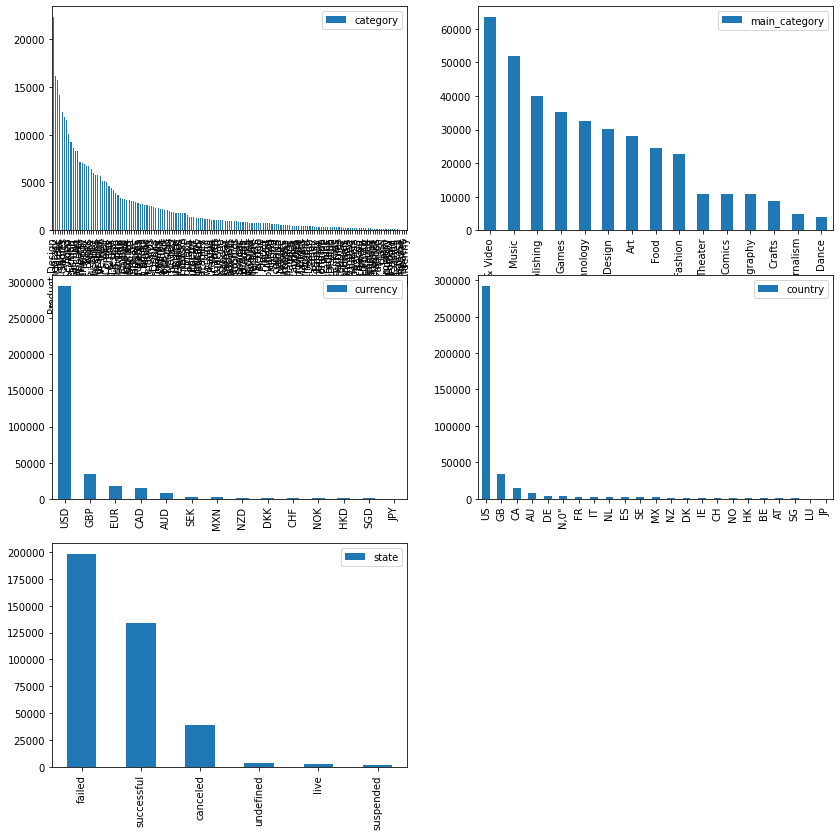

In [ ]:
fig_count = plt.figure()

for idx, cat_col in enumerate(categorical_cols):
    ax = fig_count.add_subplot(3, 2, idx + 1)

    data[cat_col].value_counts().plot(kind='bar',
                                      ax=ax,
                                      figsize=(14,14),
                                      legend=True)

plt.show()

As mentioned before, we can see that the dependant categorical column represents an imbalanced dataset.

We can also visually confirm that most of the projects are US-based and thus use USD as its currency.

## Data Transformations and Feature Engineering

After removing the *usd pledge* column and filling the 4 missing values in name. The next things we can do are:

### 1 Drop the pledged and goal column

*usd_pledged_goal* has information that has been updated and regularized so that all ammounts are in the same currency, so we should remove de redundant *goal* column.

More over, we want all money data to be in the same currency to better compare apples-to-apples.

In [ ]:
data_fixed = data.copy()

data_fixed.drop(["goal"], axis=1, inplace=True)

### 2 Change the category columns to discrete numerical values.

While categorical types are good for some data treatment, some models will need categorical data to be in discrete numerical values.


In [ ]:
for cat_col in categorical_cols:    
    data_fixed[cat_col] = data_fixed[cat_col].astype('category').cat.codes


data_fixed[categorical_cols].head(5)


,category,main_category,currency,country,state
0,108,12,5,9,1
1,93,6,13,22,1
2,93,6,13,22,1
3,90,10,13,22,1
4,55,6,13,22,0


### 3 Create a new column *campaign_duration_days* that stores the difference between the deadline - launched and remove both columns.

In [ ]:
data_fixed["campaign_duration_days"] = \
    (data_fixed.deadline - data_fixed.launched).astype('timedelta64[D]').astype(int)

data_fixed[["launched", "deadline", "campaign_duration_days"]].head(10)

,launched,deadline,campaign_duration_days
0,2015-08-11 12:12:28,2015-10-09,58
1,2017-09-02 04:43:57,2017-11-01,59
2,2013-01-12 00:20:50,2013-02-26,44
3,2012-03-17 03:24:11,2012-04-16,29
4,2015-07-04 08:35:03,2015-08-29,55
5,2016-02-26 13:38:27,2016-04-01,34
6,2014-12-01 18:30:44,2014-12-21,19
7,2016-02-01 20:05:12,2016-03-17,44
8,2014-04-24 18:14:43,2014-05-29,34
9,2014-07-11 21:55:48,2014-08-10,29


In [ ]:
data_fixed.drop(["launched", "deadline"], axis=1, inplace=True)
data_fixed.head(5)

,ID,name,category,main_category,currency,state,backers,country,usd_goal_real,campaign_duration_days
0,1000002330,The Songs of Adelaide & Abullah,108,12,5,1,0,9,1533.95,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,93,6,13,1,15,22,30000.00,59
2,1000004038,Where is Hank?,93,6,13,1,3,22,45000.00,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,90,10,13,1,1,22,5000.00,29
4,1000011046,Community Film Project: The Art of Neighborhoo...,55,6,13,0,14,22,19500.00,55


### 4 Tokenize the *name* column, remove stop words and encode the presence of the top 50 most common tokens.

Let's first see if there are records that share the same exact name and how many records there are.

In [ ]:
cnt = data_fixed.groupby(["name"]).size().reset_index(name='count')
cnt[cnt["count"] > 1].sort_values(by=['count'], ascending=False)

,name,count
212354,New EP/Music Development,41
65438,Canceled (Canceled),13
205249,Music Video,11
208195,N/A (Canceled),11
212334,New EP / Music Development,10
...,...,...
138805,Harvard Student Art Show,2
138566,Hare Watches,2
138545,Hardwire Media Center,2
138067,Hannah's Huggables,2


We see that there are various projects with the same name, we can tokenize and encode the presence of the most common tokens.

We'll use a Tfidf Vectorizer to determine those terms that are most relevant in the whole corpus of the name column, to do this, we'll:
1. Strip any accent characters
1. Remove stop words
1. Limit it to the 50 most important tokens
1. A valid token is one that is at least 2 letters and may have additional alphanumerical characters. The tokens will be converted to lowercase
1. These new 50 features for each row will replace the *name* column in the data, we'll prefix these new columns with *name_* so as to remember where they came from.

In [ ]:
vectorizer = TfidfVectorizer(
    strip_accents="unicode",
    stop_words=ENGLISH_STOP_WORDS,
    binary=False,
    max_features=50,
    token_pattern=u'(?ui)\\b\\w*[a-z]{2,}\\w*\\b'
)
word_tfidf_vector = vectorizer.fit_transform(data_fixed["name"])

print(f"Top TF-IDF Tokens to generate {word_tfidf_vector.shape} tokens:")
print(vectorizer.get_feature_names())

Top TF-IDF Tokens to generate (378661, 50) tokens:
['adventure', 'album', 'american', 'app', 'art', 'book', 'canceled', 'card', 'cards', 'cd', 'children', 'city', 'clothing', 'collection', 'comic', 'dance', 'debut', 'documentary', 'ep', 'feature', 'festival', 'film', 'food', 'free', 'game', 'help', 'home', 'kids', 'life', 'live', 'love', 'magazine', 'make', 'man', 'mobile', 'movie', 'music', 'new', 'novel', 'playing', 'project', 'record', 'series', 'short', 'story', 'studio', 'time', 'tour', 'video', 'world']


In [ ]:
name_features = pd.DataFrame(word_tfidf_vector.toarray(),
                             columns=vectorizer.get_feature_names())
name_features = name_features.add_prefix("name_")
display(name_features.head(5))

,name_adventure,name_album,name_american,name_app,name_art,name_book,name_canceled,name_card,name_cards,name_cd,...,name_project,name_record,name_series,name_short,name_story,name_studio,name_time,name_tour,name_video,name_world
0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.646081,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.608472,0.0,0.0,0.0,0.0,0.0,...,0.560767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_fixed_2 = data_fixed.copy()

data_fixed_2 = pd.concat([data_fixed_2, name_features], axis=1)

display(data_fixed_2)

,ID,name,category,main_category,currency,state,backers,country,usd_goal_real,campaign_duration_days,...,name_project,name_record,name_series,name_short,name_story,name_studio,name_time,name_tour,name_video,name_world
0,1000002330,The Songs of Adelaide & Abullah,108,12,5,1,0,9,1533.95,58,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,93,6,13,1,15,22,30000.00,59,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1000004038,Where is Hank?,93,6,13,1,3,22,45000.00,44,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,90,10,13,1,1,22,5000.00,29,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1000011046,Community Film Project: The Art of Neighborhoo...,55,6,13,0,14,22,19500.00,55,...,0.560767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),39,6,13,0,1,22,50000.00,29,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
378657,999977640,The Tribe,93,6,13,1,5,22,1500.00,26,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,93,6,13,1,1,22,15000.00,45,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
378659,999987933,BioDefense Education Kit,138,13,13,1,6,22,15000.00,30,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Remove the *name* column and see that all data is now numerical

In [ ]:
data_fixed_2.drop("name", axis=1, inplace=True)
data_fixed_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 59 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      378661 non-null  int64  
 1   category                378661 non-null  int16  
 2   main_category           378661 non-null  int8   
 3   currency                378661 non-null  int8   
 4   state                   378661 non-null  int8   
 5   backers                 378661 non-null  int64  
 6   country                 378661 non-null  int8   
 7   usd_goal_real           378661 non-null  float64
 8   campaign_duration_days  378661 non-null  int64  
 9   name_adventure          378661 non-null  float64
 10  name_album              378661 non-null  float64
 11  name_american           378661 non-null  float64
 12  name_app                378661 non-null  float64
 13  name_art                378661 non-null  float64
 14  name_book           

## Outlier analysis

Let's begin with a histogram frequency count for each of the columns, we want to ignore the ID as it does not provide significant frequency data. We'll take a look at how the categorical data looks like.

We'll also ignore the *name_* columns given how many and how sparse they are.

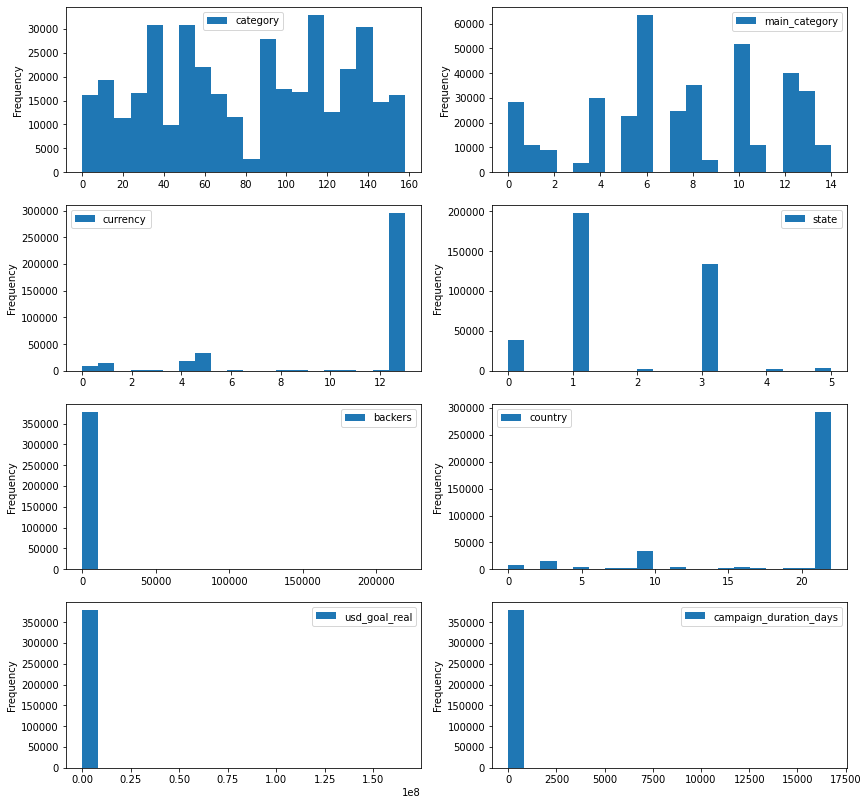

In [ ]:
# We don't want to plot the name_ features nor the ID column
columns_to_ignore = ["ID"]
columns_to_ignore.extend(list(data_fixed_2.filter(regex = 'name_')))
plot_histogram(data_fixed_2.drop(columns_to_ignore, axis=1), 4, 2)

In these histograms we see that there are categories that represent a big count. The data in these categories is unbalanced specially for the currency and country columns.

Let's see if there are many outliers in the data with a box plot. We'll focus strictly on the numerical data in:
1. usd_goal_real
1. backers
1. campaign_duration_days

In [ ]:
numerical_columns = ["usd_goal_real",
             "backers",
             "campaign_duration_days"]

data_fixed_2[numerical_columns].describe()

,usd_goal_real,backers,campaign_duration_days
count,3.786610e+05,378661.000000,378661.000000
mean,4.545440e+04,105.617476,33.481122
std,1.152950e+06,907.185035,65.909172
min,1.000000e-02,0.000000,0.000000
25%,2.000000e+03,2.000000,29.000000
50%,5.500000e+03,12.000000,29.000000
75%,1.550000e+04,56.000000,36.000000
max,1.663614e+08,219382.000000,16738.000000


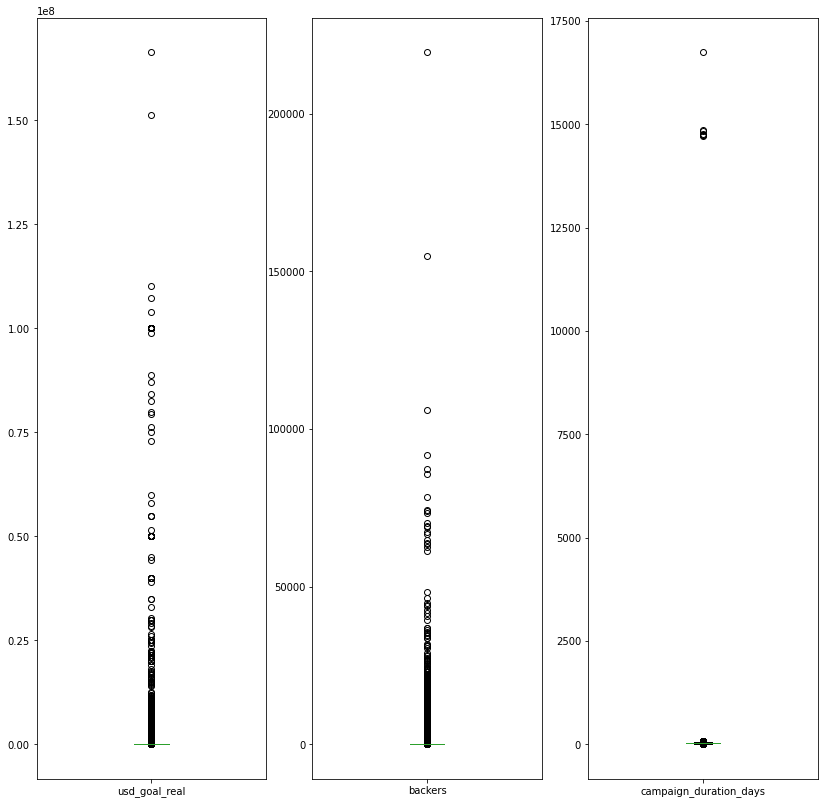

In [ ]:
data_fixed_2[numerical_columns].plot.box(subplots=True,
                                       layout=(1, 3),
                                       figsize=(14,14));

All columns have many outliers and have varying ranges of the data, which might not matter too much in some models like Decision Trees or Random Forest but will on some others.

Let's zoom in and check  how many records with outliers there are with InterQuartile Range (IQR).

Anything inside of the $IQR*1.5$ will be not be considered an outlier, anything over or under the $IQR*3.0$ will be considered an outlier.

In [ ]:
def describe_outliers_with_iqr(df: pd.DataFrame):

    for col in df.columns:
        column_data = df[col]
        iqr = column_data.quantile(0.75) - column_data.quantile(0.25)
        
        upper_limit = column_data.quantile(0.75) + (iqr * 1.5)
        upper_limit_extreme = column_data.quantile(0.75) + (iqr * 3)

        lower_limit = column_data.quantile(0.25) - (iqr * 1.5)
        lower_limit_extreme = column_data.quantile(0.25) - (iqr * 3)

        num_outliers_below_lower = df[df[col] < lower_limit_extreme].shape[0]
        num_outliers_above_upper = df[df[col] > upper_limit_extreme].shape[0]

        print_marquee(f"Outlier data for column {col}")
        print(f"IQR: {iqr}")
        print(f"Lower limit extreme: {lower_limit_extreme}")
        print(f"Lower limit: {lower_limit}")
        print(f"Upper limit: {upper_limit}")
        print(f"Upper limit extreme: {upper_limit_extreme}")

        print(f"Outliers below the lower limit: {num_outliers_below_lower}")
        print(f"Outliers above the upper limit: {num_outliers_above_upper}")


describe_outliers_with_iqr(data_fixed_2[numerical_columns])



*****************************************
* Outlier data for column usd_goal_real *
*****************************************
IQR: 13500.0
Lower limit extreme: -38500.0
Lower limit: -18250.0
Upper limit: 35750.0
Upper limit extreme: 56000.0
Outliers below the lower limit: 0
Outliers above the upper limit: 26943


***********************************
* Outlier data for column backers *
***********************************
IQR: 54.0
Lower limit extreme: -160.0
Lower limit: -79.0
Upper limit: 137.0
Upper limit extreme: 218.0
Outliers below the lower limit: 0
Outliers above the upper limit: 29013


**************************************************
* Outlier data for column campaign_duration_days *
**************************************************
IQR: 7.0
Lower limit extreme: 8.0
Lower limit: 18.5
Upper limit: 46.5
Upper limit extreme: 57.0
Outliers below the lower limit: 3951
Outliers above the upper limit: 40989


Given the big number of outliers, we can't just trim them out of the dataset, instead we will cap the outliers to be the value of the lower and upper limit extremes.

1. usd_goal_real
 * No outliers below the limit
 * Will cap higher outliers to 56000.0
1. backers
 * No outliers below the limit
 * Will cap higher outliers to 218
1. campaign_duration_days
 * Will cap lower outliers to 8
 * Will cap higher outliers to 57

In [ ]:
data_fixed_3 = data_fixed_2.copy()


data_fixed_3.loc[data_fixed_3["usd_goal_real"] > 56000, "usd_goal_real"] = 56000
data_fixed_3.loc[data_fixed_3["backers"] > 218, "backers"] = 218

data_fixed_3.loc[data_fixed_3["campaign_duration_days"] < 8, "campaign_duration_days"] = 8
data_fixed_3.loc[data_fixed_3["campaign_duration_days"] > 57, "campaign_duration_days"] = 57

In [ ]:
data_fixed_3[numerical_columns].describe()

,usd_goal_real,backers,campaign_duration_days
count,378661.000000,378661.000000,378661.000000
mean,12993.869713,44.220081,32.747125
std,16440.022262,65.677192,11.391515
min,0.010000,0.000000,8.000000
25%,2000.000000,2.000000,29.000000
50%,5500.000000,12.000000,29.000000
75%,15500.000000,56.000000,36.000000
max,56000.000000,218.000000,57.000000


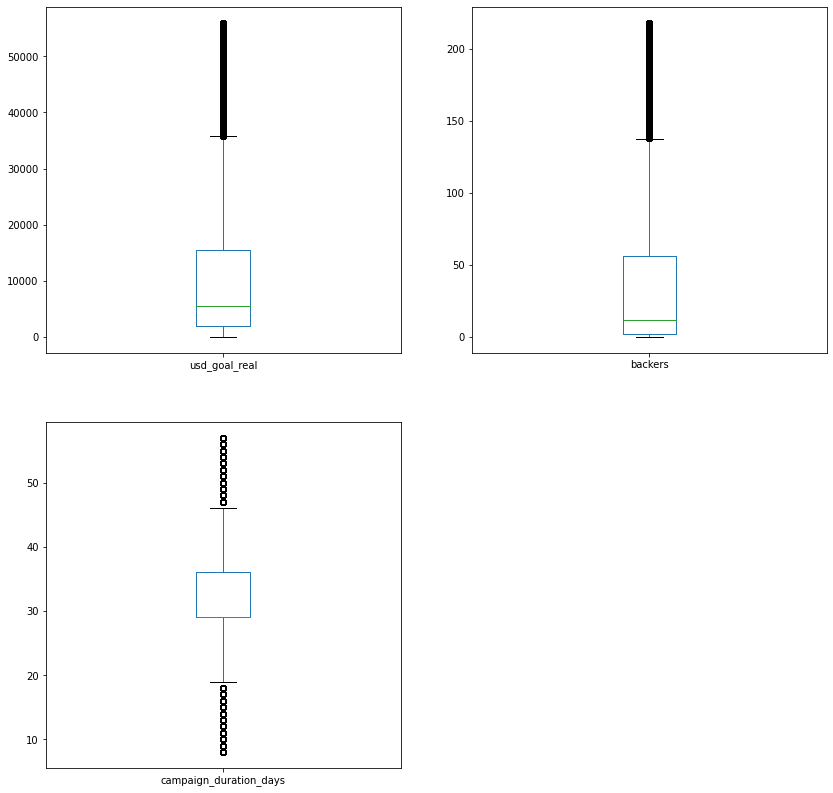

In [ ]:
data_fixed_3[numerical_columns].plot.box(subplots=True,
                                       layout=(2, 2),
                                       figsize=(14,14));

In the table and the graphs we can now see that all values in numerical columns are not above or below the $3*IQR$ and that most of the data points are inside of the IQR.

## Data Normalization
Let's further process these four numerical columns in the data by using Robust Scaling.

In robust scaling, we scale each feature of the data set by subtracting the median and then dividing by the interquartile range. The interquartile range (IQR) is defined as the difference between the third and the first quartile and represents the central 50% of the data.

This method comes in handy when working with data sets that contain many outliers because it uses statistics that are robust to outliers (median and interquartile range).

In [ ]:
data_fixed_4 = data_fixed_3.copy()

print("Before scaling:")
display(data_fixed_4[numerical_columns].describe())

print("\n\nScaled data:")
data_fixed_4[numerical_columns] = pd.DataFrame(
    RobustScaler().fit_transform(data_fixed_3[numerical_columns]),
    columns=numerical_columns)

display(data_fixed_4[numerical_columns].describe())

Before scaling:


,usd_goal_real,backers,campaign_duration_days
count,378661.000000,378661.000000,378661.000000
mean,12993.869713,44.220081,32.747125
std,16440.022262,65.677192,11.391515
min,0.010000,0.000000,8.000000
25%,2000.000000,2.000000,29.000000
50%,5500.000000,12.000000,29.000000
75%,15500.000000,56.000000,36.000000
max,56000.000000,218.000000,57.000000




Scaled data:


,usd_goal_real,backers,campaign_duration_days
count,378661.000000,378661.000000,378661.000000
mean,0.555101,0.596668,0.535304
std,1.217779,1.216244,1.627359
min,-0.407407,-0.222222,-3.000000
25%,-0.259259,-0.185185,0.000000
50%,0.000000,0.000000,0.000000
75%,0.740741,0.814815,1.000000
max,3.740741,3.814815,4.000000


We can now see that after treating the outliers and normalizing the data, all columns are roughly inside a similar range and so are the std deviation and means of the data.

It's important to note that after normalization, data may not directly tell us what its value means, i.e: there can't be negative backers or campaign days. But for the model, the normalization helps it to get better results.

## Correlation Matrix

In [ ]:
corr_matrix = data_fixed_4.drop(["ID"], axis=1).corr(method="pearson")
display(corr_matrix)

,category,main_category,currency,state,backers,country,usd_goal_real,campaign_duration_days,name_adventure,name_album,...,name_project,name_record,name_series,name_short,name_story,name_studio,name_time,name_tour,name_video,name_world
category,1.000000,0.199092,-0.012265,0.014103,0.070809,-0.012868,0.044042,-0.003565,0.019710,0.012681,...,-0.005262,0.006314,0.011578,0.042440,-0.020872,-0.004415,-0.000155,0.014384,0.018448,0.014827
main_category,0.199092,1.000000,-0.013927,-0.014582,-0.019586,-0.014337,0.065789,0.038640,0.008478,0.119239,...,-0.014536,0.048589,-0.023974,-0.038445,0.021791,-0.008315,0.006954,0.038610,0.012664,0.014613
currency,-0.012265,-0.013927,1.000000,0.057808,0.046238,0.979487,-0.028996,0.017088,-0.003068,0.039663,...,0.028341,0.026208,0.017849,-0.005772,0.011870,0.008729,0.000576,0.023652,0.009718,-0.022550
state,0.014103,-0.014582,0.057808,1.000000,0.515970,0.045667,-0.232921,-0.116876,0.003639,0.093524,...,0.004078,0.046624,-0.006185,0.049080,-0.001704,0.017215,-0.003443,0.023044,0.004852,-0.004659
backers,0.070809,-0.019586,0.046238,0.515970,1.000000,0.046130,0.132613,-0.033210,0.024009,0.029851,...,-0.023548,0.021586,-0.007112,-0.010821,0.002055,-0.003889,0.000121,-0.011388,-0.018273,0.035752
country,-0.012868,-0.014337,0.979487,0.045667,0.046130,1.000000,-0.024676,0.019129,-0.002464,0.036223,...,0.027826,0.024287,0.016868,-0.006843,0.012390,0.006720,0.000573,0.022939,0.009008,-0.021557
usd_goal_real,0.044042,0.065789,-0.028996,-0.232921,0.132613,-0.024676,1.000000,0.161510,0.001960,-0.065434,...,-0.016503,-0.026019,-0.004501,-0.050659,0.006733,-0.010712,0.006381,-0.026363,-0.017222,0.050129
campaign_duration_days,-0.003565,0.038640,0.017088,-0.116876,-0.033210,0.019129,0.161510,1.000000,-0.005172,0.024791,...,0.014184,0.012148,0.003256,-0.025579,0.008400,0.002799,0.001299,0.001685,-0.011663,0.015640
name_adventure,0.019710,0.008478,-0.003068,0.003639,0.024009,-0.002464,0.001960,-0.005172,1.000000,-0.012929,...,-0.009820,-0.004825,0.002808,-0.006693,0.000895,-0.005900,0.000572,-0.004972,-0.004584,-0.002784
name_album,0.012681,0.119239,0.039663,0.093524,0.029851,0.036223,-0.065434,0.024791,-0.012929,1.000000,...,-0.011013,0.020985,-0.019368,-0.021953,-0.015345,0.052145,-0.008584,0.007974,-0.005740,-0.020042


Let's get the independent variables that strongly correlate to the dependent variable *state*

In [ ]:
display(corr_matrix[np.abs(corr_matrix["state"]) > 0.4]["state"])

state      1.00000
backers    0.51597
Name: state, dtype: float64

We see that the *backers* is the one that best correlates to state, which makes sense because the ammount of backers may contribute to the success or failure of a project in Kickstarter.

It'd be interesting to see if there are columns that don't really correlate (less than 0.1) to the state variable as these might help simplify the model later on.

In [ ]:
display(corr_matrix[np.abs(corr_matrix["state"]) < 0.1]["state"])

category            0.014103
main_category      -0.014582
currency            0.057808
country             0.045667
name_adventure      0.003639
name_album          0.093524
name_american      -0.004415
name_app           -0.045581
name_art            0.007181
name_book           0.012712
name_card           0.001905
name_cards          0.012788
name_cd             0.032515
name_children      -0.002029
name_city           0.010038
name_clothing      -0.030040
name_collection     0.004495
name_comic          0.015544
name_dance          0.026316
name_debut          0.063612
name_documentary    0.010677
name_ep             0.060799
name_feature        0.004178
name_festival       0.031070
name_film           0.047317
name_food          -0.018181
name_free          -0.005093
name_game          -0.016479
name_help           0.014280
name_home          -0.003213
name_kids          -0.007488
name_life          -0.015072
name_live           0.003874
name_love           0.002063
name_magazine 

It would appear that the presence of certain words in the name column don't really impact the state of a project, if the models are not performing well, we might want to consider removing them from the training so as to reduce the noise.

## Train/Val/Test Split

We'll use a 80/10/10 split for the train/val/test sets.

In [ ]:
def train_val_test_split(X: pd.DataFrame, y: pd.DataFrame,
                         should_print_summary: bool = True):
    """Splits a dataset into an 80/10/10 Train/val/set split"""
    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        train_size=0.8,
                                                        random_state=42)
    # Val/Test split
    X_val, X_test, y_val, y_test = train_test_split(X_test,
                                                    y_test,
                                                    train_size=0.5,
                                                    random_state=42)

    # Ravel the labels to get it in better shape for the training
    y_train = y_train.values.ravel()
    y_val = y_val.values.ravel()
    y_test = y_test.values.ravel()

    if should_print_summary:
        print(f"X_train: {X_train.shape}")
        print(f"X_val: {X_val.shape}")
        print(f"X_test: {X_test.shape}")

        print(f"y_train: {y_train.shape}")
        print(f"y_val: {y_val.shape}")
        print(f"y_test: {y_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test


data_final = data_fixed_4.copy()

dependent_var = "state";

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    data_final.drop(dependent_var, axis=1),
    data_final[[dependent_var]])


X_train: (302928, 58)
X_val: (37866, 58)
X_test: (37867, 58)
y_train: (302928,)
y_val: (37866,)
y_test: (37867,)


Let's see the distribution of the labels (*state*) in the train dataset.

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print(data["state"].value_counts())
print(dict(zip(unique, counts)))

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64
{0: 30869, 1: 158293, 2: 2245, 3: 107204, 4: 1467, 5: 2850}


# Models

Now, we'll take the data and train on it for the following models:

1. MLP Neural Network
1. Decision tree
1. Logistic Regression
1. Random Forest
1. Naïve Bayes

We'll use accuracy as the main metric to evaluate the performance, but we'll keep an eye on the precision, recall and F1-Score in order to break ties.

## MLP Neural Network

In [ ]:
hyperparams_mlp = {
    "activation": ["logistic", "tanh", "relu"],
    "solver": ["adam", "sgd"],
    "alpha": [0.0001, 0.0003, 0.009, 0.01, 0.03, 0.1, 0.3, 0],
    "batch_size": ["auto"],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "learning_rate_init": [0.001, 0.003, 0.009],
    "shuffle": [True, False],
    "nesterovs_momentum": [True, False],
    }

mlp_search = RandomizedSearchCV(MLPClassifier(random_state=42,
                                              early_stopping=True
                                              ),
                                param_distributions=hyperparams_mlp,
                                verbose=3,
                                n_jobs=-1,
                                cv=5,
                                scoring="accuracy",
                                random_state=42,
                                n_iter=100)

search_and_evaluate_model(mlp_search,
                          X_train,
                          y_train,
                          X_val,
                          y_val)

model_2_pkl(mlp_search.best_estimator_,
            f"{data_root_location}or_mlp_best_model.pkl")



********************************************
* Searching for optimal hyperparameters... *
********************************************
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 19.1min finished


The best hyperparameters are {'solver': 'adam', 'shuffle': True, 'nesterovs_momentum': False, 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'batch_size': 'auto', 'alpha': 0.0003, 'activation': 'tanh'} with a score of 0.88


****************************
* Hyperparam search report *
****************************


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_shuffle,param_nesterovs_momentum,param_learning_rate_init,param_learning_rate,param_batch_size,...,param_activation,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,55.357844,20.763930,0.380766,0.078628,sgd,False,False,0.009,constant,auto,...,tanh,"{'solver': 'sgd', 'shuffle': False, 'nesterovs...",0.658964,0.594230,0.618559,0.765305,0.663894,0.660190,0.058563,95
1,334.810001,45.142803,0.192171,0.009485,sgd,True,True,0.001,adaptive,auto,...,relu,"{'solver': 'sgd', 'shuffle': True, 'nesterovs_...",0.875301,0.875400,0.872611,0.871717,0.875316,0.874069,0.001581,48
2,185.388991,56.411231,0.451649,0.044665,adam,True,False,0.001,adaptive,auto,...,tanh,"{'solver': 'adam', 'shuffle': True, 'nesterovs...",0.880649,0.882778,0.881326,0.881571,0.879277,0.881120,0.001150,2
3,105.739276,38.181721,0.264346,0.043898,adam,False,True,0.003,adaptive,auto,...,relu,"{'solver': 'adam', 'shuffle': False, 'nesterov...",0.877315,0.878140,0.872891,0.878963,0.876372,0.876736,0.002106,37
4,106.292354,39.507003,0.179478,0.006351,sgd,False,False,0.003,invscaling,auto,...,relu,"{'solver': 'sgd', 'shuffle': False, 'nesterovs...",0.758542,0.757782,0.759598,0.717950,0.763143,0.751403,0.016827,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,80.682696,16.736314,0.115048,0.009554,adam,False,False,0.009,adaptive,auto,...,relu,"{'solver': 'adam', 'shuffle': False, 'nesterov...",0.875994,0.878982,0.878652,0.879607,0.876851,0.878017,0.001365,24
96,37.754192,5.603684,0.367965,0.030641,sgd,False,False,0.009,constant,auto,...,logistic,"{'solver': 'sgd', 'shuffle': False, 'nesterovs...",0.664394,0.734361,0.739560,0.715887,0.754444,0.721729,0.031206,93
97,103.841547,13.747547,0.211415,0.015547,adam,False,False,0.001,constant,auto,...,logistic,"{'solver': 'adam', 'shuffle': False, 'nesterov...",0.866372,0.868683,0.863582,0.866832,0.865627,0.866219,0.001660,60
98,98.563710,19.272269,0.235820,0.009549,sgd,False,True,0.001,constant,auto,...,tanh,"{'solver': 'sgd', 'shuffle': False, 'nesterovs...",0.825026,0.809609,0.839385,0.866072,0.859800,0.839979,0.021071,78




*************************************************************
* Confusion Matrix and Prediction Report on Validation set: *
*************************************************************
[[ 2383  1456     0   125     0     0]
 [    3 18524     0  1215     0    13]
 [    0   182     0    64     0     0]
 [    0  1191     0 12133     0    11]
 [    1   160     0    35     0     0]
 [    0     5     0     0     0   365]]
Wrongly categorized elements: 4461/37866


              precision    recall  f1-score   support

           0       1.00      0.60      0.75      3964
           1       0.86      0.94      0.90     19755
           2       0.00      0.00      0.00       246
           3       0.89      0.91      0.90     13335
           4       0.00      0.00      0.00       196
           5       0.94      0.99      0.96       370

    accuracy                           0.88     37866
   macro avg       0.62      0.57      0.59     37866
weighted avg       0.88      0.88      0.87   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decision Tree

In [ ]:
hyperparams_dec_tree = {
    "ccp_alpha": [0.001, 0.01, 0.1, 0, 0.5, 1, 5],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [2,3,4,5,6],
    "min_samples_split": [2,3,4,5,6],
    "max_features": [None, "sqrt", "log2"]
    }

decision_tree_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=42),
                                                param_distributions=hyperparams_dec_tree,
                                                verbose=3,
                                                n_jobs=-1,
                                                cv=5,
                                                scoring="accuracy",
                                                random_state=42,
                                                n_iter=100)

search_and_evaluate_model(decision_tree_search,
                          X_train,
                          y_train,
                          X_val,
                          y_val)

model_2_pkl(decision_tree_search.best_estimator_,
            f"{data_root_location}or_decision_tree_best_model.pkl")



********************************************
* Searching for optimal hyperparameters... *
********************************************
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   42.9s finished


The best hyperparameters are {'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'criterion': 'entropy', 'ccp_alpha': 0.001} with a score of 0.88


****************************
* Hyperparam search report *
****************************


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_features,param_criterion,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.002623,0.255196,0.040642,0.003501,4,2,log2,gini,0.1,"{'min_samples_split': 4, 'min_samples_leaf': 2...",0.522546,0.522546,0.522546,0.522539,0.522539,0.522543,0.000004,50
1,12.620603,1.222316,0.036383,0.004341,6,4,None,entropy,0.5,"{'min_samples_split': 6, 'min_samples_leaf': 4...",0.522546,0.522546,0.522546,0.522539,0.522539,0.522543,0.000004,50
2,2.405542,0.338097,0.075845,0.011282,2,4,sqrt,gini,0,"{'min_samples_split': 2, 'min_samples_leaf': 4...",0.841911,0.835738,0.830010,0.842057,0.846942,0.839331,0.005862,18
3,12.611595,0.875849,0.040026,0.004518,5,4,None,entropy,0.1,"{'min_samples_split': 5, 'min_samples_leaf': 4...",0.777176,0.776896,0.776813,0.777354,0.773690,0.776386,0.001362,32
4,3.029919,0.570425,0.058321,0.004574,3,3,sqrt,gini,0.001,"{'min_samples_split': 3, 'min_samples_leaf': 3...",0.795134,0.750999,0.748671,0.781910,0.794801,0.774303,0.020553,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8.419604,0.243016,0.024808,0.001278,4,4,None,entropy,1,"{'min_samples_split': 4, 'min_samples_leaf': 4...",0.522546,0.522546,0.522546,0.522539,0.522539,0.522543,0.000004,50
96,2.496680,0.308409,0.032830,0.006301,4,3,log2,entropy,0.5,"{'min_samples_split': 4, 'min_samples_leaf': 3...",0.522546,0.522546,0.522546,0.522539,0.522539,0.522543,0.000004,50
97,2.144601,0.228807,0.057996,0.007194,5,5,sqrt,entropy,0,"{'min_samples_split': 5, 'min_samples_leaf': 5...",0.832205,0.837834,0.835259,0.850078,0.850276,0.841131,0.007599,17
98,2.308940,0.278563,0.035694,0.008676,2,4,sqrt,entropy,0.01,"{'min_samples_split': 2, 'min_samples_leaf': 4...",0.717212,0.713795,0.787360,0.698407,0.736734,0.730702,0.030846,45




*************************************************************
* Confusion Matrix and Prediction Report on Validation set: *
*************************************************************
[[ 2383  1413     0   165     0     3]
 [    2 18215     0  1531     0     7]
 [    0   180     0    66     0     0]
 [    0  1097     0 12227     0    11]
 [    1   156     0    39     0     0]
 [    0     0     0     0     0   370]]
Wrongly categorized elements: 4671/37866


              precision    recall  f1-score   support

           0       1.00      0.60      0.75      3964
           1       0.86      0.92      0.89     19755
           2       0.00      0.00      0.00       246
           3       0.87      0.92      0.89     13335
           4       0.00      0.00      0.00       196
           5       0.95      1.00      0.97       370

    accuracy                           0.88     37866
   macro avg       0.61      0.57      0.58     37866
weighted avg       0.87      0.88      0.87   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression

In [ ]:
hyperparams = {
    "C": [0.001, 0.01, 0.1, 1, 5, 10, 15, 20, 50, 100],
    "penalty": ["none", "l1", "l2"],
    "solver": ["lbfgs", "saga"]
    }

logistic_regression_search = RandomizedSearchCV(LogisticRegression(random_state=42),
                                                param_distributions=hyperparams,
                                                verbose=3,
                                                n_jobs=-1,
                                                cv=5,
                                                scoring="accuracy",
                                                random_state=2,
                                                n_iter=30)


search_and_evaluate_model(logistic_regression_search,
                          X_train,
                          y_train,
                          X_val,
                          y_val)

model_2_pkl(logistic_regression_search.best_estimator_,
            f"{data_root_location}or_log_regression_best_model.pkl")



********************************************
* Searching for optimal hyperparameters... *
********************************************
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of 150 | elapsed:   35.7s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  93 out of 150 | elapsed:  1.9min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done 144 out of 150 | elapsed:  2.5min remaining:    6.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.6min finished


The best hyperparameters are {'solver': 'saga', 'penalty': 'l1', 'C': 5} with a score of 0.85


****************************
* Hyperparam search report *
****************************


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_penalty,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,34.181097,0.900113,0.044317,0.002576,lbfgs,none,15,"{'solver': 'lbfgs', 'penalty': 'none', 'C': 15}",0.792576,0.811871,0.782953,0.792704,0.782421,0.792505,0.010658,15
1,33.040190,1.041530,0.055689,0.015547,lbfgs,none,0.001,"{'solver': 'lbfgs', 'penalty': 'none', 'C': 0....",0.792576,0.811871,0.782953,0.792704,0.782421,0.792505,0.010658,15
2,114.187752,1.325850,0.034635,0.005764,saga,l2,20,"{'solver': 'saga', 'penalty': 'l2', 'C': 20}",0.849652,0.850345,0.850130,0.851465,0.849979,0.850314,0.000618,2
3,115.856627,1.544785,0.036506,0.004427,saga,none,100,"{'solver': 'saga', 'penalty': 'none', 'C': 100}",0.849652,0.850345,0.850130,0.851465,0.849979,0.850314,0.000618,2
4,117.677930,1.133441,0.034829,0.002864,saga,l2,1,"{'solver': 'saga', 'penalty': 'l2', 'C': 1}",0.849635,0.850328,0.850114,0.851465,0.849979,0.850304,0.000622,10
5,33.173712,1.192482,0.051892,0.012227,lbfgs,l2,20,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 20}",0.796587,0.819315,0.788648,0.792044,0.796418,0.798602,0.010770,14
6,116.941735,1.566085,0.040757,0.005814,saga,l2,10,"{'solver': 'saga', 'penalty': 'l2', 'C': 10}",0.849652,0.850345,0.850130,0.851465,0.849979,0.850314,0.000618,2
7,34.455732,1.483058,0.047419,0.003784,lbfgs,l2,5,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 5}",0.794837,0.810055,0.781286,0.791103,0.784633,0.792383,0.010032,21
8,114.818832,2.600657,0.036557,0.003762,saga,none,50,"{'solver': 'saga', 'penalty': 'none', 'C': 50}",0.849652,0.850345,0.850130,0.851465,0.849979,0.850314,0.000618,2
9,0.231933,0.065486,0.000000,0.000000,lbfgs,l1,10,"{'solver': 'lbfgs', 'penalty': 'l1', 'C': 10}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,27




*************************************************************
* Confusion Matrix and Prediction Report on Validation set: *
*************************************************************
[[ 2365  1454     0   143     0     2]
 [    2 18717     0  1029     0     7]
 [    0   190     0    56     0     0]
 [    1  2278     0 11053     0     3]
 [    1   167     0    28     0     0]
 [    0   302     0     0     0    68]]
Wrongly categorized elements: 5663/37866


              precision    recall  f1-score   support

           0       1.00      0.60      0.75      3964
           1       0.81      0.95      0.87     19755
           2       0.00      0.00      0.00       246
           3       0.90      0.83      0.86     13335
           4       0.00      0.00      0.00       196
           5       0.85      0.18      0.30       370

    accuracy                           0.85     37866
   macro avg       0.59      0.43      0.46     37866
weighted avg       0.85      0.85      0.84   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest

In [ ]:
hyperparams_rf = {
    "ccp_alpha": [0.001, 0.01, 0.1, 0, 0.5, 1, 5],
    "criterion": ["gini", "entropy"],
    "n_estimators": [100, 250, 500, 750],
    "min_samples_leaf": [2,3,4,5,6],
    "min_samples_split": [2,3,4,5,6],
    "max_features": [None, "sqrt", "log2"]
    }

rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=42,
                                                      oob_score=True,
                                                      bootstrap=True),
                                param_distributions=hyperparams_rf,
                                verbose=3,
                                n_jobs=-1,
                                cv=5,
                                scoring="accuracy",
                                random_state=42,
                                n_iter=100)

search_and_evaluate_model(rf_search,
                          X_train,
                          y_train,
                          X_val,
                          y_val)

model_2_pkl(rf_search.best_estimator_,
            f"{data_root_location}or_rf_best_model.pkl")



********************************************
* Searching for optimal hyperparameters... *
********************************************
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed: 29.9min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 148.4min finished


The best hyperparameters are {'n_estimators': 750, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': None, 'criterion': 'entropy', 'ccp_alpha': 0} with a score of 0.89


****************************
* Hyperparam search report *
****************************


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_criterion,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1049.032891,15.307657,5.189693,0.365700,750,2,4,log2,entropy,0.1,"{'n_estimators': 750, 'min_samples_split': 2, ...",0.522546,0.522546,0.522546,0.522539,0.522539,0.522543,0.000004,62
1,528.011731,4.233613,3.568217,0.086029,100,6,6,None,entropy,0,"{'n_estimators': 100, 'min_samples_split': 6, ...",0.884049,0.885848,0.884742,0.885830,0.884377,0.884969,0.000743,2
2,147.645591,1.447912,0.730413,0.029862,100,4,3,log2,entropy,0.1,"{'n_estimators': 100, 'min_samples_split': 4, ...",0.522546,0.522546,0.522546,0.614310,0.689923,0.574375,0.067830,60
3,1909.473349,9.553035,1.566896,0.102563,250,6,3,None,entropy,1,"{'n_estimators': 250, 'min_samples_split': 6, ...",0.522546,0.522546,0.522546,0.522539,0.522539,0.522543,0.000004,62
4,671.942739,6.911194,8.021747,0.277461,500,6,6,log2,gini,0.001,"{'n_estimators': 500, 'min_samples_split': 6, ...",0.854504,0.850361,0.851649,0.853181,0.850078,0.851955,0.001683,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1202.249354,10.765300,1.133062,0.217973,250,5,5,None,entropy,5,"{'n_estimators': 250, 'min_samples_split': 5, ...",0.522546,0.522546,0.522546,0.522539,0.522539,0.522543,0.000004,62
96,151.172760,2.233187,0.649275,0.053368,100,6,6,sqrt,entropy,5,"{'n_estimators': 100, 'min_samples_split': 6, ...",0.522546,0.522546,0.522546,0.522539,0.522539,0.522543,0.000004,62
97,920.473623,50.364898,3.065743,0.279823,750,4,6,sqrt,entropy,0.1,"{'n_estimators': 750, 'min_samples_split': 4, ...",0.763955,0.754729,0.763642,0.740216,0.753800,0.755269,0.008656,58
98,322.493635,5.023623,1.269593,0.158036,250,4,5,log2,gini,1,"{'n_estimators': 250, 'min_samples_split': 4, ...",0.522546,0.522546,0.522546,0.522539,0.522539,0.522543,0.000004,62




*************************************************************
* Confusion Matrix and Prediction Report on Validation set: *
*************************************************************
[[ 2387  1445     0   129     0     3]
 [    5 18488     0  1255     0     7]
 [    0   184     0    62     0     0]
 [    1   994     0 12329     0    11]
 [    1   155     0    40     0     0]
 [    0     0     0     0     0   370]]
Wrongly categorized elements: 4292/37866


              precision    recall  f1-score   support

           0       1.00      0.60      0.75      3964
           1       0.87      0.94      0.90     19755
           2       0.00      0.00      0.00       246
           3       0.89      0.92      0.91     13335
           4       0.00      0.00      0.00       196
           5       0.95      1.00      0.97       370

    accuracy                           0.89     37866
   macro avg       0.62      0.58      0.59     37866
weighted avg       0.88      0.89      0.88   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Naïve Bayes

One of the side-effects of normalizing the data is that some values that were strictly natural numbers before the normalization, may now have negative real values.

Naïve Bayes models, however, do not accept values under 0. Our other models don't really care about that so just for this one model we'll temporarily use the dataset as it was before the normalization and scaling.

In [ ]:
X_train_nb, X_val_nb, X_test_nb, y_train_nb, y_val_nb, y_test_nb = train_val_test_split(
    data_fixed_3.drop(dependent_var, axis=1),
    data_fixed_3[[dependent_var]])


X_train: (302928, 58)
X_val: (37866, 58)
X_test: (37867, 58)
y_train: (302928,)
y_val: (37866,)
y_test: (37867,)


In [ ]:
nb_model = CategoricalNB()
nb_model.fit(X_train_nb.drop(["ID"], axis=1),
             y_train_nb)

print_marquee("Confusion matrix and prediction report on validation dataset:")

y_pred_bayes = nb_model.predict(X_val_nb.drop(["ID"], axis=1))

print_metrics(y_val_nb, y_pred_bayes)

model_2_pkl(nb_model,
            f"{data_root_location}or_naivebayes_best_model.pkl")



*****************************************************************
* Confusion matrix and prediction report on validation dataset: *
*****************************************************************
[[ 1610  1941    28   377     6     2]
 [  137 16833    81  2665    32     7]
 [    6   165    15    58     2     0]
 [   20  1856    43 11361    44    11]
 [    5   154     1    32     4     0]
 [    0     0     0     0     0   370]]
Wrongly categorized elements: 7673/37866


              precision    recall  f1-score   support

           0       0.91      0.41      0.56      3964
           1       0.80      0.85      0.83     19755
           2       0.09      0.06      0.07       246
           3       0.78      0.85      0.82     13335
           4       0.05      0.02      0.03       196
           5       0.95      1.00      0.97       370

    accuracy                           0.80     37866
   macro avg       0.60      0.53      0.55     37866
weighted avg       0.80      0.80 

## Evaluation on Validation Data Set


After running all of the models on the validation dataset, we find the following results on each of the metrics:

&nbsp;|Accuracy|Macro F1|W F1|
:---  |---:    |---:|---:|
MLP NN|0.88|0.57|0.88|
Decision Tree|0.88|0.57|0.88|
Logistic Regression|0.85|0.43|0.85|
Random Forest|0.89|0.58|0.89|
Naïve Bayes|0.80|0.53|0.80|

We can see that the MLP NN, Random Forest and Decision Tree had similar performance, with really good accuracy overall. Their training times and final size of the fitted model differ though, Decision Tree was the fastest and lightest to train, while the Random Forest took the longest and the more space on disk.

These results look very promising, but we must be cautious given that using the accuracy metric may be deceiving.

By taking a look at the confusion matrices for each of these top models we can see that both the Random Forest and Decision Tree didn't even attempted to classify any record as being of *state* 2 and 4 and this is reflected in the Macro F1-Score.

One big reason for this is how imbalanced the original data set is, to recall, this is the distribution of classes as seen during the EDA:

|State|Counts|
|:---|---:|
|failed     |  197719|
|successful |  133956|
|canceled   |   38779|
|undefined  |    3562|
|live       |    2799|
|suspended  |    1846|

We can see that the *undefined, live and suspended* states are underrepresented when compared against *failed and successful*.

A hypothesis for the fact that the models don't even try to classify any record in states 2 and 4 is because they just don't have enough examples to learn from and that the training is skewing towards the most represented classes.

This is the reason why using accuracy as the only metric can be deceiving: a high value might indicate that it is correctly classifying most of the data, because most of the data belongs to only one or two classes.



# Suggested improvements

We'll try to do something regarding this imbalance of classes and retrain the best models found to see if we can get even better results to try on the test dataset.

There are many ways to tackle this problem, and we will first treat the data to level the count of each class. We could oversample the underreprented classes or we could downscale all classes to a random subset that has similar classes for all.

One thing we can notice is that the the *undefined, live and suspended* columns don't really say much about the data. Let's do the following:

1. Undefined. This shows that the data colected for these projects may be unreliable and given the low number of 3562 records, we can safely remove these without affecting the rest of the dataset.
1. Live. Represents projects that have an active campaign and thus their state is bound to change at any time. Given that we want to predict final states only, and the low number of records, we can remove this from the dataset.
1. Suspended. The suspended status means that a project *may* be restarted at a later undetermined date. For our purposes we can reclassify records in this category as cancelled.

## Refactorization of records with some label

Given that we transformed the categorical state types to discrete numbers, let's figure out who's who first by taking a look at the counts for each and then apply the factorization that we just mentioned.

In [ ]:
print(data_final["state"].value_counts())
print(data['state'].value_counts())

1    197719
3    133956
0     38779
5      3562
2      2799
4      1846
Name: state, dtype: int64
failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64


In [ ]:
def factorize_redundant_states(df: pd.DataFrame):
    df = df.copy()

    # Drop the undefined
    df.drop(df[df['state'] == 5].index, inplace = True) 

    # Drop the live
    df.drop(df[df['state'] == 2].index, inplace = True)

    # Change those who were suspended to canceled
    df.loc[df["state"] == 4, "state"] = 0

    return df

data_final_clean_labels = factorize_redundant_states(data_fixed_4)
print(data_final_clean_labels['state'].value_counts())

1    197719
3    133956
0     40625
Name: state, dtype: int64


## Resplit the dataset into Train/Val/Test sets

This is necessary in order to keep the proportions after removing records from the dataset

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    data_final_clean_labels.drop(dependent_var, axis=1),
    data_final_clean_labels[[dependent_var]])


X_train: (297840, 58)
X_val: (37230, 58)
X_test: (37230, 58)
y_train: (297840,)
y_val: (37230,)
y_test: (37230,)


# Retraining of the best model

The RandomForest, DecisionTree and MLP NN had similar results during the first round of training.

For the best models we'll chose the MLP NN and Decision Tree mainly because of their ease of training and using the best hyperparameters found during previous searches.

## MLP NN

In [ ]:
best_mlp_model = MLPClassifier(random_state=42,
                               early_stopping=True,
                               solver='adam',
                               shuffle=True,
                               nesterovs_momentum=False,
                               learning_rate_init= 0.009,
                               learning_rate='invscaling',
                               batch_size='auto',
                               alpha= 0,
                               activation='relu')

print_marquee("Training of MLP NN Model")

best_mlp_model.fit(X_train.drop(["ID"], axis=1),
                   y_train)

best_mlp_score = best_mlp_model.score(X_train.drop(["ID"], axis=1),
                                      y_train)

print(f"Score for model during training: {best_mlp_score}")

print_marquee("Confusion matrix and evaluation on validation set")

y_val_pred = best_mlp_model.predict(X_val.drop(["ID"], axis=1))

print_metrics(y_val, y_val_pred)

model_2_pkl(best_mlp_model,
            f"{data_root_location}or_final_mlp_best_model.pkl")



****************************
* Training of MLP NN Model *
****************************
Score for model during training: 0.8849247918345421


*****************************************************
* Confusion matrix and evaluation on validation set *
*****************************************************
[[ 2314  1586   172]
 [    2 18385  1308]
 [    1  1180 12282]]
Wrongly categorized elements: 4249/37230


              precision    recall  f1-score   support

           0       1.00      0.57      0.72      4072
           1       0.87      0.93      0.90     19695
           3       0.89      0.91      0.90     13463

    accuracy                           0.89     37230
   macro avg       0.92      0.80      0.84     37230
weighted avg       0.89      0.89      0.88     37230



## Decision Tree

In [ ]:
best_dt_model = DecisionTreeClassifier(random_state=42,
                                       min_samples_split= 6,
                                       min_samples_leaf= 4,
                                       criterion= 'entropy',
                                       ccp_alpha= 0.001)

print_marquee("Training of Decision Tree Model")

best_dt_model.fit(X_train.drop(["ID"], axis=1),
               y_train)

best_dt_score = best_dt_model.score(X_train.drop(["ID"], axis=1),
                                    y_train)

print(f"Score for model during training: {best_dt_score}")

print(best_dt_model.score(X_train.drop(["ID"], axis=1),
                       y_train))

print_marquee("Confusion matrix and evaluation on validation set")

y_val_pred = best_dt_model.predict(X_val.drop(["ID"], axis=1))
print_metrics(y_val, y_val_pred)

model_2_pkl(best_dt_model,
            f"{data_root_location}or_final_dt_best_model.pkl")



***********************************
* Training of Decision Tree Model *
***********************************
Score for model during training: 0.8823529411764706
0.8823529411764706


*****************************************************
* Confusion matrix and evaluation on validation set *
*****************************************************
[[ 2314  1561   197]
 [    1 18144  1550]
 [    1  1108 12354]]
Wrongly categorized elements: 4418/37230


              precision    recall  f1-score   support

           0       1.00      0.57      0.72      4072
           1       0.87      0.92      0.90     19695
           3       0.88      0.92      0.90     13463

    accuracy                           0.88     37230
   macro avg       0.92      0.80      0.84     37230
weighted avg       0.89      0.88      0.88     37230



---

## Conclusions

We can see that both the MLP NN and Decision Tree were able to get really good results across the board.

We can also see that the F1-Score improved a lot after applying the refactorization of records and that the overall accuracy of the model didn't suffer for it.

# Test Set Results

We'll use both models to test how well they fare generalizing on new data.

## MLP NN

In [ ]:
print_marquee("MLP NN - Confusion matrix and evaluation on test set")

y_test_pred = best_mlp_model.predict(X_test.drop(["ID"], axis=1))

print_metrics(y_test, y_test_pred)



********************************************************
* MLP NN - Confusion matrix and evaluation on test set *
********************************************************
[[ 2316  1602   192]
 [    0 18575  1303]
 [    0  1180 12062]]
Wrongly categorized elements: 4277/37230


              precision    recall  f1-score   support

           0       1.00      0.56      0.72      4110
           1       0.87      0.93      0.90     19878
           3       0.89      0.91      0.90     13242

    accuracy                           0.89     37230
   macro avg       0.92      0.80      0.84     37230
weighted avg       0.89      0.89      0.88     37230



## Decision Tree

In [ ]:
print_marquee("Decision Tree - Confusion matrix and evaluation on test set")

y_test_pred = best_dt_model.predict(X_test.drop(["ID"], axis=1))
print_metrics(y_test, y_test_pred)



***************************************************************
* Decision Tree - Confusion matrix and evaluation on test set *
***************************************************************
[[ 2316  1563   231]
 [    0 18421  1457]
 [    0  1120 12122]]
Wrongly categorized elements: 4371/37230


              precision    recall  f1-score   support

           0       1.00      0.56      0.72      4110
           1       0.87      0.93      0.90     19878
           3       0.88      0.92      0.90     13242

    accuracy                           0.88     37230
   macro avg       0.92      0.80      0.84     37230
weighted avg       0.89      0.88      0.88     37230



---
## Conclusions

We can verify that the results on the test set are similar to those obtained using the training and validation sets.

This tells us that the models were able to generalize properly to unseen data.

# Evaluation of the live projects

As part of our improvement phase, we decided to remove those records that had an active campaign, that is, those who still didn't have a final state.

We can repurpose those records and try to predict what their final state will be given their current features. This would effectively simulate real-world data.

As a reminder, this is the mapping of states:
* failed = 1
* successful = 3
* canceled = 0
* live = 2

Let's recover those records that had their state set to 2 (live) and remove this state column as we will now predict them.

In [ ]:
live_projects = data_fixed_4[data_fixed_4['state'] == 2].copy()
display(live_projects.head(5))

live_projects.drop(["state"], axis=1, inplace=True)

,ID,category,main_category,currency,state,backers,country,usd_goal_real,campaign_duration_days,name_adventure,...,name_project,name_record,name_series,name_short,name_story,name_studio,name_time,name_tour,name_video,name_world
40,1000149007,95,12,1,2,0.222222,3,-0.229899,4.000000,0.0,...,0.694164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183,1000761521,142,6,13,2,-0.148148,22,-0.037037,2.142857,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
458,1002183790,69,6,5,2,-0.018519,9,-0.321527,-1.714286,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537,1002599057,55,6,13,2,-0.203704,22,-0.259259,4.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
544,1002629894,70,0,8,2,-0.222222,15,-0.403532,-2.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def get_successful_failed_canceled_projects(df: pd.DataFrame,
                                            original_df: pd.DataFrame) -> tuple:
    """
    Matches the group of succesful, failed and canceled projects to the priginal
    unprocessed data.
    """

    successful_ids = df[df["state"]==3]["ID"]
    successful_projects = original_df[original_df['ID'].isin(successful_ids)]

    failed_ids = df[df["state"]==1]["ID"]
    failed_projects = original_df[original_df['ID'].isin(failed_ids)]

    canceled_ids = df[df["state"]==0]["ID"]
    canceled_projects = original_df[original_df['ID'].isin(canceled_ids)]

    return successful_projects, failed_projects, canceled_projects

def get_most_common_in_column(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    cnt = df.groupby(columns).size().reset_index(name='count')
    return cnt[cnt["count"] > 1].sort_values(by=['count'], ascending=False)

## MLP NN

In [ ]:
y_live_mlp_predictions = best_mlp_model.predict(live_projects.drop(["ID"], axis=1))

live_projects_mlp_predictions = live_projects.copy()
live_projects_mlp_predictions["state"] = y_live_mlp_predictions
live_projects_mlp_predictions.head()

live_projects_mlp_predictions["state"].value_counts()

1    2131
3     668
Name: state, dtype: int64

In [ ]:
successful_mlp_projects, \
failed_mlp_projects, _ = get_successful_failed_canceled_projects(live_projects_mlp_predictions,
                                        data)

print_marquee("10 Successful projects as predicted by MLP")
display(successful_mlp_projects.head(10))

print_marquee("10 Failed projects as predicted by MLP")
display(failed_mlp_projects.head(10))



**********************************************
* 10 Successful projects as predicted by MLP *
**********************************************


,ID,name,category,main_category,currency,deadline,goal,launched,state,backers,country,usd_goal_real
40,1000149007,Unschooling To University Book Project,Nonfiction,Publishing,CAD,2018-01-19,3000.0,2017-11-20 18:15:14,live,24,CA,2396.36
458,1002183790,The Man in the Field,Horror,Film & Video,GBP,2018-01-08,850.0,2017-12-21 11:19:18,live,11,GB,1159.38
894,1004434782,DIY BOXCAT by Rato Kim - The Vinyl Art Toy Pla...,DIY,Crafts,USD,2018-01-06,2023.0,2017-12-04 17:26:58,live,77,US,2023.00
1603,100822204,Freedom Ride Jacket | Revolutionizing Urban Cy...,Product Design,Design,USD,2018-01-20,20000.0,2017-11-21 15:02:31,live,474,US,20000.00
2267,1011784198,Through the Eyes of My Mother,Photobooks,Photography,USD,2018-01-05,500.0,2017-12-29 23:15:36,live,7,US,500.00
2392,1012399283,"""The Woman in White""",Horror,Film & Video,USD,2018-01-27,1200.0,2017-12-16 19:50:55,live,13,US,1200.00
2856,101483724,The Advent Storybook,Children's Books,Publishing,USD,2018-01-04,18500.0,2017-12-04 13:32:13,live,85,US,18500.00
3338,1017252588,"My Debut EP - ""Shine!"" - PHASE 1",Pop,Music,USD,2018-01-09,5000.0,2017-12-10 22:44:19,live,41,US,5000.00
4039,1020721729,Edensoles | Sole To Soul Comfort with Dynamic ...,Product Design,Design,USD,2018-01-11,5000.0,2017-12-12 18:50:44,live,962,US,5000.00
4134,1021242831,Plume: the Omnibus,Comics,Comics,USD,2018-01-12,25000.0,2017-12-11 16:00:02,live,842,US,25000.00




******************************************
* 10 Failed projects as predicted by MLP *
******************************************


,ID,name,category,main_category,currency,deadline,goal,launched,state,backers,country,usd_goal_real
183,1000761521,KILOS.,Thrillers,Film & Video,USD,2018-02-06,5000.0,2017-12-23 20:34:31,live,4,US,5000.00
537,1002599057,Dear Atlantas,Film & Video,Film & Video,USD,2018-02-16,2000.0,2017-12-18 02:48:27,live,1,US,2000.00
544,1002629894,Art Calendar 2018,Illustration,Art,MXN,2018-01-06,1000.0,2017-12-21 05:34:12,live,0,MX,52.32
627,100301082,"Feliz año nuevo, mamá.",Theater,Theater,MXN,2018-02-04,49000.0,2017-12-06 03:36:06,live,2,MX,2563.83
641,1003104071,One GuitarMan Band,Music,Music,EUR,2018-01-17,2000.0,2017-12-18 00:02:46,live,0,IT,2427.39
752,1003665581,Durango Falls TV Show,Film & Video,Film & Video,USD,2018-01-20,10000.0,2017-11-21 10:56:11,live,1,US,10000.00
783,1003819770,GrandLo Café,Drinks,Food,USD,2018-01-19,25000.0,2017-11-20 19:54:51,live,38,US,25000.00
842,100411349,E Coin Mining and Rig-Building Workshop,Hardware,Technology,USD,2018-01-06,3100.0,2017-11-22 20:28:28,live,9,US,3100.00
990,1005020458,Tiddly Trailer Bar Co.,Drinks,Food,USD,2018-01-02,9500.0,2017-11-03 21:36:22,live,36,US,9500.00
1427,1007266579,Pedal Whip Multitool,Hardware,Technology,USD,2018-01-05,1500.0,2017-12-06 19:20:22,live,6,US,1500.00


In [ ]:
print_marquee("Top Successful Categories - MLP")

display(get_most_common_in_column(successful_mlp_projects,
                                  ["main_category", "category"]).head(10))

print_marquee("Top Failed Categories - MLP")
display(get_most_common_in_column(failed_mlp_projects,
                                  ["main_category", "category"]).head(10))



***********************************
* Top Successful Categories - MLP *
***********************************


,main_category,category,count
749,Design,Product Design,86
1408,Games,Tabletop Games,60
1680,Music,Music,22
797,Fashion,Accessories,21
2128,Technology,Gadgets,19
1420,Games,Video Games,18
70,Art,Illustration,16
802,Fashion,Apparel,16
1083,Film & Video,Shorts,15
10,Art,Art,14




*******************************
* Top Failed Categories - MLP *
*******************************


,main_category,category,count
749,Design,Product Design,151
802,Fashion,Apparel,93
2075,Technology,Apps,78
1420,Games,Video Games,68
2205,Technology,Technology,66
1680,Music,Music,58
1009,Film & Video,Film & Video,51
2023,Publishing,Publishing,50
10,Art,Art,49
1408,Games,Tabletop Games,48


## Decision Tree

In [ ]:
y_live_dt_predictions = best_dt_model.predict(live_projects.drop(["ID"], axis=1))

live_projects_dt_predictions = live_projects.copy()
live_projects_dt_predictions["state"] = y_live_dt_predictions
live_projects_dt_predictions.head()

live_projects_dt_predictions["state"].value_counts()

1    2099
3     700
Name: state, dtype: int64

In [ ]:
successful_dt_projects, \
failed_dt_projects, _ = get_successful_failed_canceled_projects(live_projects_dt_predictions,
                                        data)

print_marquee("10 Successful projects as predicted by DT")
display(successful_dt_projects.head(10))

print_marquee("10 Failed projects as predicted by DT")
display(failed_dt_projects.head(10))



*********************************************
* 10 Successful projects as predicted by DT *
*********************************************


,ID,name,category,main_category,currency,deadline,goal,launched,state,backers,country,usd_goal_real
40,1000149007,Unschooling To University Book Project,Nonfiction,Publishing,CAD,2018-01-19,3000.0,2017-11-20 18:15:14,live,24,CA,2396.36
894,1004434782,DIY BOXCAT by Rato Kim - The Vinyl Art Toy Pla...,DIY,Crafts,USD,2018-01-06,2023.0,2017-12-04 17:26:58,live,77,US,2023.00
990,1005020458,Tiddly Trailer Bar Co.,Drinks,Food,USD,2018-01-02,9500.0,2017-11-03 21:36:22,live,36,US,9500.00
1603,100822204,Freedom Ride Jacket | Revolutionizing Urban Cy...,Product Design,Design,USD,2018-01-20,20000.0,2017-11-21 15:02:31,live,474,US,20000.00
2856,101483724,The Advent Storybook,Children's Books,Publishing,USD,2018-01-04,18500.0,2017-12-04 13:32:13,live,85,US,18500.00
3338,1017252588,"My Debut EP - ""Shine!"" - PHASE 1",Pop,Music,USD,2018-01-09,5000.0,2017-12-10 22:44:19,live,41,US,5000.00
4039,1020721729,Edensoles | Sole To Soul Comfort with Dynamic ...,Product Design,Design,USD,2018-01-11,5000.0,2017-12-12 18:50:44,live,962,US,5000.00
4134,1021242831,Plume: the Omnibus,Comics,Comics,USD,2018-01-12,25000.0,2017-12-11 16:00:02,live,842,US,25000.00
4641,1023678642,Toggle: Thinnest Wood Sliding Camera Cover,Product Design,Design,USD,2018-02-01,1400.0,2017-12-05 17:51:35,live,53,US,1400.00
4687,1023873527,S19: Gabardina o Trench ST PATRICK,Ready-to-wear,Fashion,MXN,2018-01-20,55000.0,2017-12-01 13:01:06,live,34,MX,2877.77




*****************************************
* 10 Failed projects as predicted by DT *
*****************************************


,ID,name,category,main_category,currency,deadline,goal,launched,state,backers,country,usd_goal_real
183,1000761521,KILOS.,Thrillers,Film & Video,USD,2018-02-06,5000.0,2017-12-23 20:34:31,live,4,US,5000.00
458,1002183790,The Man in the Field,Horror,Film & Video,GBP,2018-01-08,850.0,2017-12-21 11:19:18,live,11,GB,1159.38
537,1002599057,Dear Atlantas,Film & Video,Film & Video,USD,2018-02-16,2000.0,2017-12-18 02:48:27,live,1,US,2000.00
544,1002629894,Art Calendar 2018,Illustration,Art,MXN,2018-01-06,1000.0,2017-12-21 05:34:12,live,0,MX,52.32
627,100301082,"Feliz año nuevo, mamá.",Theater,Theater,MXN,2018-02-04,49000.0,2017-12-06 03:36:06,live,2,MX,2563.83
641,1003104071,One GuitarMan Band,Music,Music,EUR,2018-01-17,2000.0,2017-12-18 00:02:46,live,0,IT,2427.39
752,1003665581,Durango Falls TV Show,Film & Video,Film & Video,USD,2018-01-20,10000.0,2017-11-21 10:56:11,live,1,US,10000.00
783,1003819770,GrandLo Café,Drinks,Food,USD,2018-01-19,25000.0,2017-11-20 19:54:51,live,38,US,25000.00
842,100411349,E Coin Mining and Rig-Building Workshop,Hardware,Technology,USD,2018-01-06,3100.0,2017-11-22 20:28:28,live,9,US,3100.00
1427,1007266579,Pedal Whip Multitool,Hardware,Technology,USD,2018-01-05,1500.0,2017-12-06 19:20:22,live,6,US,1500.00


In [ ]:
print_marquee("Top Successful Categories - DT")

display(get_most_common_in_column(successful_dt_projects,
                                  ["main_category", "category"]).head(10))

print_marquee("Top Failed Categories - DT")
display(get_most_common_in_column(failed_dt_projects,
                                  ["main_category", "category"]).head(10))



**********************************
* Top Successful Categories - DT *
**********************************


,main_category,category,count
749,Design,Product Design,95
1408,Games,Tabletop Games,65
797,Fashion,Accessories,22
1680,Music,Music,20
1420,Games,Video Games,19
2128,Technology,Gadgets,18
70,Art,Illustration,18
1378,Games,Playing Cards,18
2205,Technology,Technology,18
10,Art,Art,16




******************************
* Top Failed Categories - DT *
******************************


,main_category,category,count
749,Design,Product Design,142
802,Fashion,Apparel,94
2075,Technology,Apps,78
1420,Games,Video Games,67
2205,Technology,Technology,62
1680,Music,Music,60
1009,Film & Video,Film & Video,51
2023,Publishing,Publishing,47
10,Art,Art,47
993,Film & Video,Documentary,45


---

## Conclusions

We can see that both models predicted that most of the projects would fail. The model doesn't expect any of the projects in the *live* category to be canceled.

Interestingly, both models kept relatively the same failed/successful ratio which again confirms their similarity as seen during the validation and test phases.

|State|MLP|Decision Tree|
|:---|---:|---:|
|Failed|2131|2099|
|Successful|668|700|

# Final Conclusions

As with any Data Science project, EDA and data treatment is essential to a good model. Data is everything, no matter how great the hyperparamentes for the model are, the model will output garbage if it is fed garbage.

In this particular case we had to:

1. Choose to use the USD variant of the columns in order to be able to compare apples to apples and dropped the original pledged and goal columns
1. Do feature engineering and create a new column called *campaign_duration_days* out of the deadline and launched columns.
1. Use the name column and apply tokenization to get the top 50 most common tokens which proved to be useful on models such as the MLP Neural Network and decision trees.
1. Do a proper treatment of outliers using the Interquartile Range (IQR)
1. Do data scaling and normalization so that numerical columns had similar values and didn't skew the model too much.

Naive Bayes was the worst performant, but not by too much and logistic regression didn't do too bad.

We got the best results with MLP Neural Networks, Decision Tree and Random Forest. We had 88% accuracy in these models, however, we had less-than ideal F1-Scores which takes into account the precision and recall of the model. This is the reason why using accuracy as the only metric can be misleading, we needed to pay attention to why we were getting such low F1-Scores.

We found that the undefined, suspended and live projects were underrepresented and that they were hardly classified by any model. But we decided that undefined projects didn't have relevant data so we could remove them from training; the suspended projects could arguably be grouped with the canceled projects. And most importantly, the live projects could be used as real-world data to use our best model with.

After factorizing these columns, we could confirm that the models still had a 88% accuracy but a much better F1-Score of 0.80-0.89 for macro and weighted scores. Which tells us that the model is more confident about the kind of predictions it is making.

The best models were Decision Tree and MLP Neural Networks, chosen both because of their performance on the validation set, the relative ease of configuration and less amount of training time.

It's worth noting that while Decision Trees work really good on this kind of problems, they have trouble performing well extrapolating to data that was not seen during training, columns that contain time series such as dates are a good example of this.

MLP Neural Networks, on the other hand, are better at extrapolating data that was not seen during training, which for this particular problem is probable that will happen with projects that have periods of time that are bigger than the ones seen during training.

Given these reasons, MLP Neural Network would probably be a better fit to continuosly make predictions on new data from crowdfunding projects.

Finally, the data shows that Product design, tabletop games and gadgets are the type of projects that have a better chance to succeed on Kickstarter. Paradoxically, product design is also one of the categories that usually fail along with fashion apparel and apps. The fact that product design appears in both categories might be due to it being the biggest category in the platform.

The amount of days of a campaign and the number of backers seem to be better factors at predicting the final state of a campaing, which confirms what was seen in the correlation matrix.